In [1]:
from bins import Bins
from utils import calcAllChi2, calcOneChi2, HistMaker, diffHist
from ROOT import TFile, TH1, TCanvas, TStyle, gStyle
import math

Welcome to JupyROOT 6.28/04


In [2]:

bins = Bins.readFrom("ranges.yml")
histMakerData = HistMaker("apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat", "_data", bins)
histsData = histMakerData.makeHists()
histMakerMC = HistMaker("medium_isotropic_eff_ag1230ag_np_9deg.dat", "_MC", bins    )

#outfile = TFIle("out.root","RECREATE")
allHistsMC = []

#calcAllChi2(histsMC, histsData)

iter 0
Before processing events 15:26:10
After processing events 15:26:10
iter 1
Before processing events 15:26:44
After processing events 15:26:47


In [3]:
import torch

torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [4]:
TH1.SetDefaultSumw2

N_PARAMS = 3

In [5]:
#lb = -1
#ub = 1

#bounds = torch.tensor([[lb]*N_PARAMS, [ub]*N_PARAMS], dtype=torch.float)
bounds = torch.tensor([[0, 0,         0],
                       [1, 2*math.pi, 2]], dtype=torch.float)

grid_r   = torch.linspace(bounds[0][0], bounds[1][0], 101)
grid_phi = torch.linspace(bounds[0][1], bounds[1][1], 101)
grid_z   = torch.linspace(bounds[0][2], bounds[1][2], 101)

grid_x1, grid_x2, grid_x3 = torch.meshgrid(grid_r, grid_phi, grid_z, indexing="ij")

xs = torch.vstack([grid_x1.flatten(), grid_x2.flatten(), grid_x3.flatten()]).transpose(-2,-1)

In [6]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    _num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=1)
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


def fit_gp_model(train_x, train_y, num_train_iters=500):
    # declare the GP
    noise = 1e-4

    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(train_x, train_y, likelihood)
    model.likelihood.noise = noise

    # train the hyperparameter (the constant)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    model.train()
    likelihood.train()

    for i in range(num_train_iters):
        optimizer.zero_grad()

        output = model(train_x)
        loss = -mll(output, train_y)

        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()

    return model, likelihood

In [7]:
num_queries = 200
num_repeats = 1
num_samples = 1

In [8]:
def lambdas(xx):
   # return x[0], x[1], x[2]
    r, phi, z = xx[0], xx[1], xx[2]
    x = r*math.cos(phi)
    y = r*math.sin(phi)
    lambda_theta = 0.5 * (2*x + z)
    lambda_phi   = 0.25 * (-2 - 2*x + 3*z)
    lambda_theta_phi = y/math.sqrt(2.)
    return lambda_theta, lambda_phi, lambda_theta_phi

def all_lambdas(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)
            yield torch.tensor([lambda_theta, lambda_phi, lambda_theta_phi])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

def constraint1(xx):
    print("In the constraint fucntion, xx = ", xx)
    input_shape = xx.shape
    ll = list(xx.shape)
    ll[-1] = 1
    if len(input_shape)>1:
        xx = torch.reshape(xx, input_shape[1:])
        output_shape = tuple(ll)
        result = 1+xx[0,0]+xx[0,1]
    else:
        result = 1+xx[0]+xx[1]
        output_shape = (1,)
        
    print(xx)
    print(input_shape)
    print(result)
    print(output_shape)
    
    return torch.reshape(torch.tensor([result],requires_grad=xx.requires_grad),output_shape)

#def cost(xx):
#    def generator(xx):
#        for x in xx:
#            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)#
#
#            result = 0
#
#            if pow(1-lambda_phi, 2) - pow(lambda_theta-lambda_phi, 2) < 4*pow(lambda_theta_phi, 2):
#                result = 1
#            if 1 + lambda_theta + 2*lambda_phi < 0:
#                result = 1

#            yield torch.tensor([result])
#    return torch.stack([a for a in generator(xx)])
    
HIST_INDEX = 5  

def objective(xx):
    def generator(xx):
        for x in xx:
            lambda_theta, lambda_phi, lambda_theta_phi = lambdas(x)

            histsMC = histMakerMC.makeHists(lambda_theta, lambda_phi, lambda_theta_phi)
            chi2, ndf = calcOneChi2(histsMC[0][HIST_INDEX], histsData[0][HIST_INDEX])
            allHistsMC.append(histsMC[0][HIST_INDEX])
            if not chi2 or not ndf:
                return torch.tensor([0])
            yield torch.tensor([1.0/(chi2 / ndf)])
           # yield torch.tensor([1./(chi2 / ndf)])
    return torch.stack([a for a in generator(xx)])

In [9]:
# -2 is the default value when no feasible has been found
default_value = 4000
feasible_incumbents = torch.ones((num_repeats, num_queries)) * default_value

for trial in range(num_repeats):
    print("trial", trial)

    torch.manual_seed(trial)
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(num_samples, 3)
    train_utility = objective(train_x)

    for i in tqdm(range(num_queries)):
        print("query", i)

        feasible_incumbents[trial, i] = train_utility.max()
        utility_model, utility_likelihood = fit_gp_model(
            train_x, train_utility.squeeze(-1)
        )
        best_f = train_utility.max()
                
        policy = botorch.acquisition.monte_carlo.qExpectedImprovement(
            model=utility_model,
            best_f=train_utility.max(),
        )

        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=RuntimeWarning)
            next_x, acq_val = botorch.optim.optimize_acqf(
                policy,
                bounds=bounds,
                q=1,
                num_restarts=40,
                raw_samples=100,
            #    nonlinear_inequality_constraints=[constraint1],
                inequality_constraints=[(torch.tensor([0,2]),torch.tensor([-2.0,-1.0],dtype=torch.float),-2.0)],
            #    ic_generator=botorch.optim.initializers.gen_batch_initial_conditions
            )

        next_utility = objective(next_x)

        train_x = torch.cat([train_x, next_x])
        train_utility = torch.cat([train_utility, next_utility])


trial 0


  0%|          | 0/200 [00:00<?, ?it/s]

query 0


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 1


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 2


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 3
query 4
query 5
query 6


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 7


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:27:11
After reweighting hists 15:27:11
query 8


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 9


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 10


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 11


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 12


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 13


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 14
query 15
query 16


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 17


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:27:40
After reweighting hists 15:27:41
query 18


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 19


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 20


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 21


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 22


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 23


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 24


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 25
query 26
query 27
Before reweighting hists 15:28:09
After reweighting hists 15:28:09
query 28


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 29


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 30


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 31


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 32


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 33


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 34


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 35


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 36


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 37


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:28:42
After reweighting hists 15:28:42
query 38


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 39


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 40


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 41


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 42


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 43


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 44


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 45


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 46


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 47


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:29:15
After reweighting hists 15:29:15
query 48


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 49


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 50


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 51


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 52


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 53


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 54


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 55


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 56


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 57


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:29:48
After reweighting hists 15:29:48
query 58


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 59


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 60


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 61


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 62


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 63


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 64


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 65


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 66


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 67


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:30:22
After reweighting hists 15:30:23
query 68


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 69


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 70


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 71


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 72


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 73


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 74


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 75


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 76


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 77


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:31:00
After reweighting hists 15:31:00
query 78


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 79


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 80


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 81


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 82


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 83


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 84


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 85


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 86


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 87


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:31:38
After reweighting hists 15:31:38
query 88
query 89


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 90


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 91


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 92


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 93


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 94


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 95


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 96


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 97


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:32:17
After reweighting hists 15:32:18
query 98


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 99


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 100


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 101


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 102


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 103


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 104


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 105


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 106


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 107


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:32:56
After reweighting hists 15:32:56
query 108


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 109


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 110


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 111


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 112
query 113


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 114


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 115


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 116


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 117


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:33:33
After reweighting hists 15:33:33
query 118


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 119


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 120


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 121


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 122


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 123


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 124


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 125


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 126


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 127


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:34:12
After reweighting hists 15:34:12
query 128


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 129


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 130


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 131


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 132


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 133


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 134


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 135


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 136


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 137


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:35:00
After reweighting hists 15:35:00
query 138


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 139


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 140


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 141


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 142


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 143


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 144
query 145


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 146


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 147


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:35:44
After reweighting hists 15:35:45
query 148


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 149


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 150


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 151


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 152


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 153
query 154


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 155


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 156


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 157


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:36:30
After reweighting hists 15:36:31
query 158


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 159


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 160


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 161


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 162


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 163


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 164


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 165


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 166


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 167


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:37:19
After reweighting hists 15:37:19
query 168


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 169


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 170


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 171


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 172
query 173


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 174


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 175


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 176


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 177


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:38:10
After reweighting hists 15:38:11
query 178


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 179


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 180


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 181


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 182


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 183


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 184


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 185


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 186


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 187


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:39:09
After reweighting hists 15:39:09
query 188


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 189


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 190


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 191


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 192


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 193


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 194


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 195


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 196


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 197


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Before reweighting hists 15:40:10
After reweighting hists 15:40:10
query 198


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


query 199


/Users/harabasz/miniforge3/envs/pyroot/lib/python3.11/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


In [10]:
torch.save(feasible_incumbents, f"./incumbents.pth")
fout = TFile("out.root", "RECREATE")
fout.cd()
for hist in allHistsMC:
    print ("Writing hist: ", hist.GetName())
    hist.Write()
for j, hists in enumerate(histsData):
    for k, hist in enumerate(hists):
            hist.Write()
            print ("Writing hist: ", j, k, hist)
fout.Close()

Writing hist:  hist_150to300_p01p08_MC_iter2
Writing hist:  hist_150to300_p01p08_MC_iter3
Writing hist:  hist_150to300_p01p08_MC_iter4
Writing hist:  hist_150to300_p01p08_MC_iter5
Writing hist:  hist_150to300_p01p08_MC_iter6
Writing hist:  hist_150to300_p01p08_MC_iter7
Writing hist:  hist_150to300_p01p08_MC_iter8
Writing hist:  hist_150to300_p01p08_MC_iter9
Writing hist:  hist_150to300_p01p08_MC_iter10
Writing hist:  hist_150to300_p01p08_MC_iter11
Writing hist:  hist_150to300_p01p08_MC_iter12
Writing hist:  hist_150to300_p01p08_MC_iter13
Writing hist:  hist_150to300_p01p08_MC_iter14
Writing hist:  hist_150to300_p01p08_MC_iter15
Writing hist:  hist_150to300_p01p08_MC_iter16
Writing hist:  hist_150to300_p01p08_MC_iter17
Writing hist:  hist_150to300_p01p08_MC_iter18
Writing hist:  hist_150to300_p01p08_MC_iter19
Writing hist:  hist_150to300_p01p08_MC_iter20
Writing hist:  hist_150to300_p01p08_MC_iter21
Writing hist:  hist_150to300_p01p08_MC_iter22
Writing hist:  hist_150to300_p01p08_MC_ite

In [11]:
t = torch.tensor( [ [-1.0000, -0.4678,  0.5433]])
print(t)
print(t.shape)

tensor([[-1.0000, -0.4678,  0.5433]])
torch.Size([1, 3])


In [12]:
with torch.no_grad():
    predictive_distribution = utility_likelihood(utility_model(xs))
    predictive_mean = predictive_distribution.mean
    predictive_lower, predictive_upper = predictive_distribution.confidence_region()


In [13]:
from ipywidgets import interact, Layout, IntSlider
import numpy as np

axis_titles = [r"R of cone coordinates", r"$\Phi$ of cone coordinates", r"Z of cone coordinates"]

def oneplot(ax, tensor, index, cmap, title, transpose=None):
        
        global xs
        tensor_3d = torch.reshape(tensor, (101,101,101))
        xs_3d = torch.reshape(xs, (101,101,101,3))
        if transpose:
               tensor_3d = tensor_3d.transpose(transpose[0],transpose[1])
               xs_3d     = xs_3d    .transpose(transpose[0],transpose[1])
        if transpose is None:
                extent=[
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                ]
        elif transpose == (0,1):
                extent=[
                        xs_3d[0][0][0][0],
                        xs_3d[0][-1][0][0],
                        xs_3d[0][0][0][2],
                        xs_3d[0][0][-1][2],
                ]
        elif transpose == (0,2):
                extent=[
                        xs_3d[0][0][0][1],
                        xs_3d[0][-1][0][1],
                        xs_3d[0][0][0][0],
                        xs_3d[0][0][-1][0],
                ]
        if transpose is None:
                x_title=axis_titles[1]
                y_title=axis_titles[2]
        elif transpose == (0, 1):
                x_title=axis_titles[0]
                y_title=axis_titles[2]
        elif transpose == (0,2):
                x_title=axis_titles[1]
                y_title=axis_titles[0]
        
        pos = ax.imshow(tensor_3d[index], cmap=cmap, interpolation="nearest", origin="lower", 
                vmin=tensor.min(), vmax=tensor.max(), extent=extent)
        ax.set_aspect((extent[1]-extent[0])/(extent[3]-extent[2]))
        ax.set_title(title)
        ax.set_xlabel(x_title)
        ax.set_ylabel(y_title)
        plt.colorbar(pos,fraction=0.046, pad=0.04)

def ff(x, transpose):
        cmap = "gist_rainbow"
        fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
        oneplot(ax[0], predictive_mean, x, cmap, "value", transpose)
        oneplot(ax[1], predictive_upper-predictive_lower, x, cmap, "confidence int. width", transpose)

def f(x):
        ff(x, None)

interact(f, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))


interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.f(x)>

In [14]:
def g(x):
        ff(x, (0,1))
           
interact(g, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))

interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.g(x)>

In [15]:
def h(x):
        ff(x, (0,2))
           
interact(h, x=IntSlider(50, 0, 100, 1, layout=Layout(width='500px')))

interactive(children=(IntSlider(value=50, description='x', layout=Layout(width='500px')), Output()), _dom_clas…

<function __main__.h(x)>

In [16]:
lds = all_lambdas(train_x)
lambda_thetas     = lds.transpose(-2,-1)[0]
lambda_phis       = lds.transpose(-2,-1)[1]
lambda_theta_phis = lds.transpose(-2,-1)[2]
c = torch.stack((
    torch.arange(0,200, dtype=int),
    lambda_thetas[0:200],
    lambda_phis[0:200],
    lambda_theta_phis[0:200],
    train_utility.squeeze()[0:200],
    (feasible_incumbents==feasible_incumbents.max())[0],
    feasible_incumbents[0]
),0).transpose(-2,-1)
torch.set_printoptions(precision=4,threshold=10_000, linewidth=120)
print(c)

tensor([[ 0.0000e+00,  1.4517e-01, -3.9563e-01, -3.4861e-01,  2.4397e+03,  0.0000e+00,  2.4397e+03],
        [ 1.0000e+00,  4.3991e-01, -4.5304e-03, -3.2986e-01,  3.8093e+03,  0.0000e+00,  3.8093e+03],
        [ 2.0000e+00, -3.7373e-01, -1.9562e-01, -3.7715e-01,  2.5717e+03,  0.0000e+00,  3.8093e+03],
        [ 3.0000e+00,  2.9956e-01,  8.5219e-02, -9.7784e-02,  4.0231e+03,  0.0000e+00,  4.0231e+03],
        [ 4.0000e+00,  4.2359e-01,  2.7046e-01, -2.9994e-01,  3.3113e+03,  0.0000e+00,  4.0231e+03],
        [ 5.0000e+00,  2.7676e-01,  7.2927e-02, -2.1392e-01,  3.8943e+03,  0.0000e+00,  4.0231e+03],
        [ 6.0000e+00,  2.6935e-01,  4.7759e-02, -1.0734e-01,  4.0280e+03,  0.0000e+00,  4.0280e+03],
        [ 7.0000e+00,  8.1512e-01, -4.1922e-01, -3.0096e-01,  2.7610e+03,  0.0000e+00,  4.0280e+03],
        [ 8.0000e+00,  7.4537e-01,  6.9733e-01, -6.4723e-02,  1.9396e+03,  0.0000e+00,  4.0280e+03],
        [ 9.0000e+00,  2.4269e-01, -2.7564e-01, -3.1777e-02,  3.1691e+03,  0.0000e+00,  4.0

Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


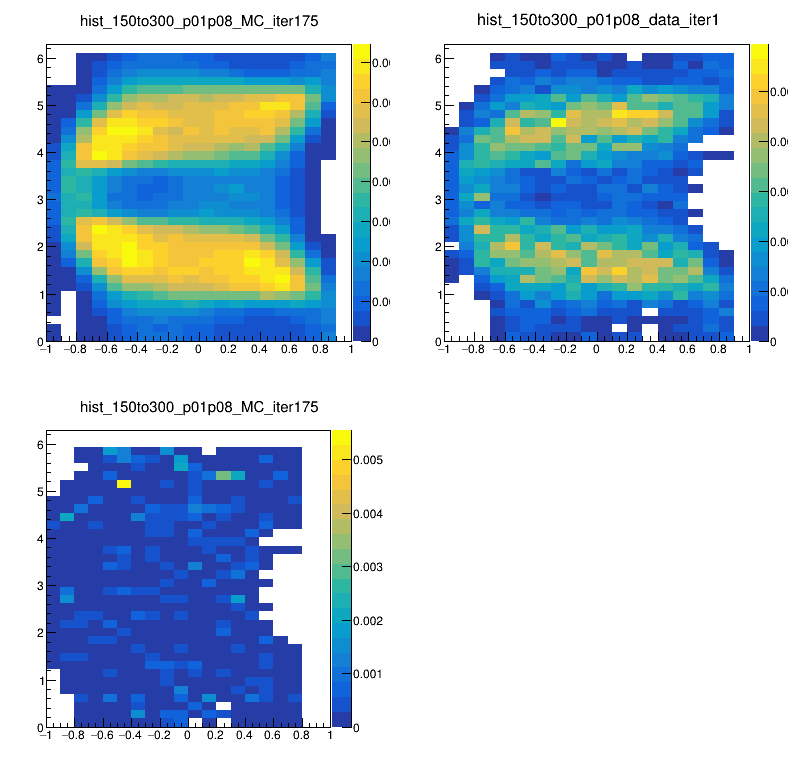

In [21]:
gStyle.SetOptStat(0)

def plotComparison(histMC, histData):
    can = TCanvas("can","can",800,800)
    can.Divide(2,2)
    can.Draw()
    can.cd(1)
    histMC.Draw("COLZ")
    can.cd(2)
    histData.Draw("COLZ")
    pad = can.cd(3)
    pad.SetRightMargin(0.155)
    pad = can.cd(3)
    hdiff = diffHist(histMC, histData)
    hdiff.Draw("COLZ")
    can.Update()
    palette = hdiff.GetListOfFunctions().FindObject("palette")
    palette.SetX1NDC(0.85)
    palette.SetX2NDC(0.9)
    can.Modified()
    can.Update()
    return can, hdiff

bestIndex = int(c[c[:,5]>0][0][0])

can1, hdiff1 = plotComparison(allHistsMC[bestIndex], histsData[0][HIST_INDEX])


Warning in <TCanvas::Constructor>: Deleting canvas with same name: can


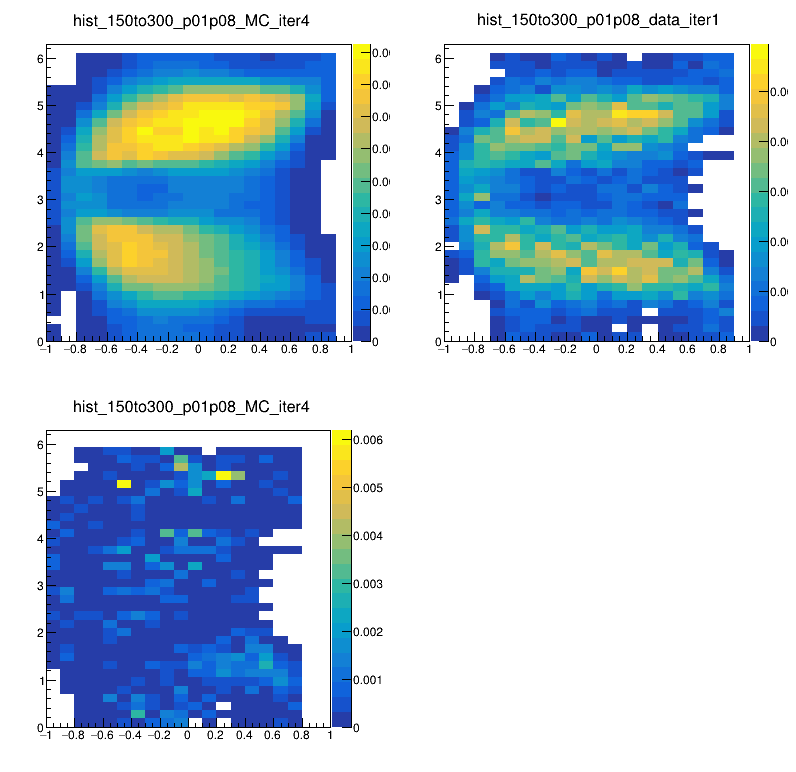

In [22]:
can2, hdiff2, = plotComparison(allHistsMC[2], histsData[0][HIST_INDEX])

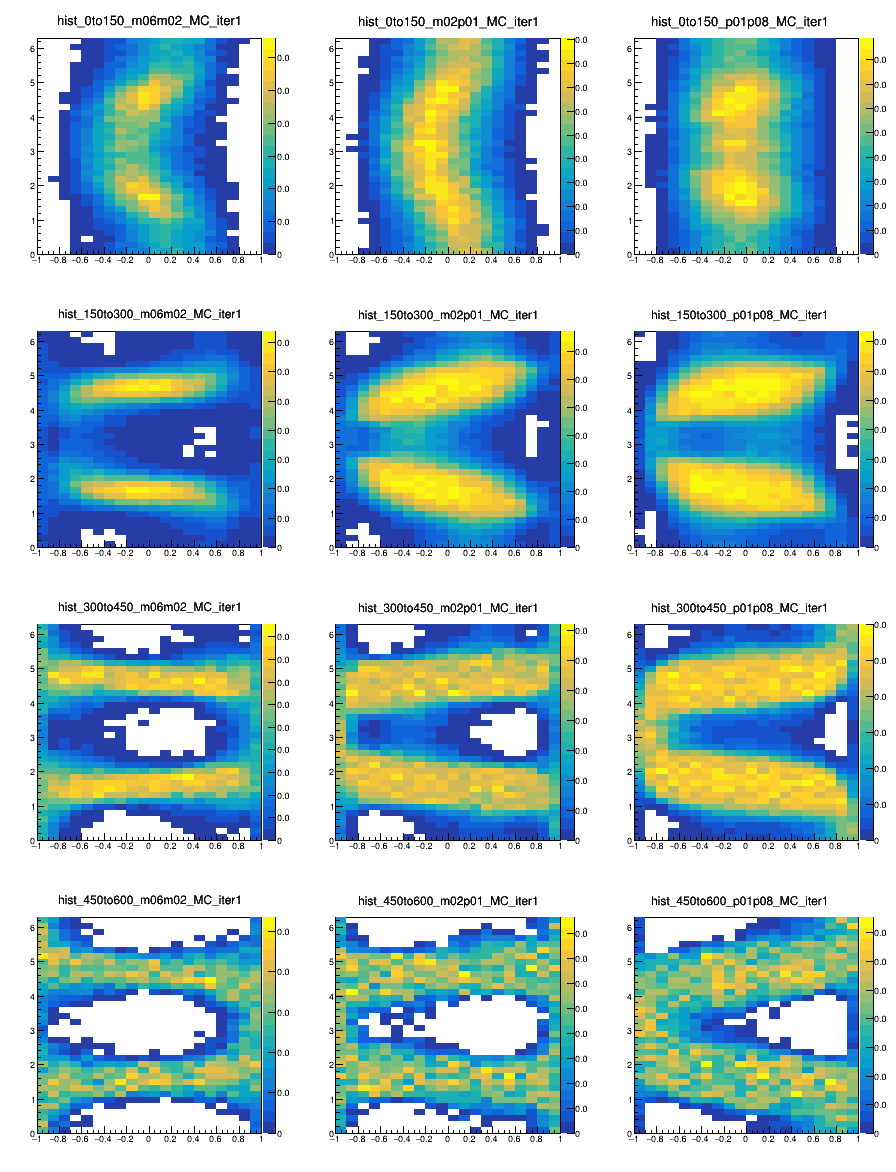

In [19]:
base_hists = histMakerMC.builder.base_hists
can3 = TCanvas("c","C",900,1200)
can3.Divide(3,4)
can3.Draw()
for i, hist in enumerate(base_hists[0]):
    can3.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


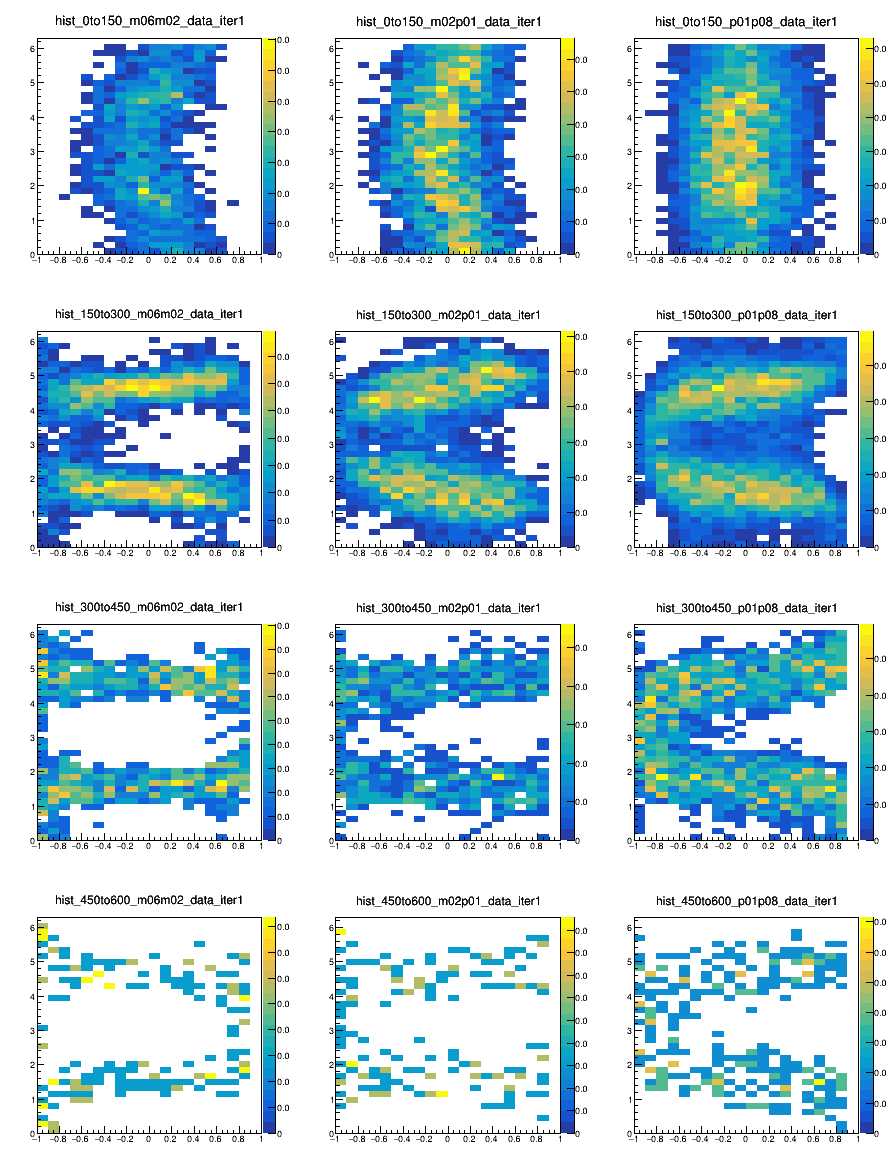

In [20]:
can4 = TCanvas("c","C",900,1200)
can4.Divide(3,4)
can4.Draw()
for i, hist in enumerate(histsData[0]):
    can4.cd(i+1)
    if not isinstance(hist, list):
        hist.Draw("COLZ")
    else:
        print(hist)